# *Weather Forecasting Model in HaNoi*  
- Nguyen Ngoc Chuong  BA12-032   

In this project, effort has been made to examine two machine learning models for weather prediction namely Univariate Time Series with SARIMA and with LSTM. It's also discuss the steps followed to get the results then analyze and compared them to each models based on Root mean squared Error. Then found that Time Series based LSTM model does the best job of predicting the weather.

## I. Set up

In [19]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pylab import rcParams
import itertools
import statsmodels.api as sm

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

## II. Data Preprocessing   
Data preprocessing is a data mining technique that involves transforming raw data into a usable format.  In order to train the
model on this dataset, we used the following preprocessing techniques.

### Data preparation 

To begin with, we need to read the data from the CSV file, then combine and convert the columns `Year`, `Month`, `Day` into one `datetime` index column

In [2]:
data=pd.read_csv('dataset.csv',
                 header=None, sep=',', skiprows=14, na_values='-999', 
                 names=['Year','Month','Day','Temperature','Precipitation','Humidity','Pressure','Wind Speed'])

data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']],errors='ignore')
'''The reason why we have to use errors="ignore" is because not all the dates we are parsing that are in the correct format.
If we use errors="coerce" then any dates that cannot be converted will be set to NaT.'''
data=data.drop(columns=['Year','Month','Day'])
data=data.set_index('Date')
data.head()

,Temperature,Precipitation,Humidity,Pressure,Wind Speed
Date,,,,,
1985-01-01,16.52,0.43,9.58,100.77,2.41
1985-01-02,18.64,0.55,10.80,100.72,2.64
1985-01-03,20.19,0.84,11.78,100.66,3.81
1985-01-04,14.82,0.31,7.87,101.09,3.66
1985-01-05,13.51,0.19,6.65,101.10,2.59


In [3]:
# Check the shape of the data
data.shape

(14335, 5)

We use this command to show the number of missing values in each column and clean the data by removing rows with missing values later on.

In [4]:
data.isnull().sum()

Temperature      0
Precipitation    0
Humidity         0
Pressure         0
Wind Speed       0
dtype: int64

In [5]:
data=data.dropna()
data.isnull().sum()

Temperature      0
Precipitation    0
Humidity         0
Pressure         0
Wind Speed       0
dtype: int64

Use `describe()` to return a statistically description of the data

In [6]:
data.describe().round(3)

,Temperature,Precipitation,Humidity,Pressure,Wind Speed
count,14335.000,14335.000,14335.000,14335.000,14335.000
mean,23.553,3.991,14.986,100.097,2.743
std,5.424,9.013,4.791,0.712,0.974
min,3.900,0.000,3.170,98.060,0.800
25%,19.700,0.020,11.230,99.500,2.040
50%,25.050,0.450,15.620,100.050,2.590
75%,27.870,3.380,19.410,100.650,3.270
max,37.170,167.310,23.250,102.700,12.450


### Plotting the Data

Now, we can plot all the features based on the new dataframe that we have created before in order to see the patterns of each feature.

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

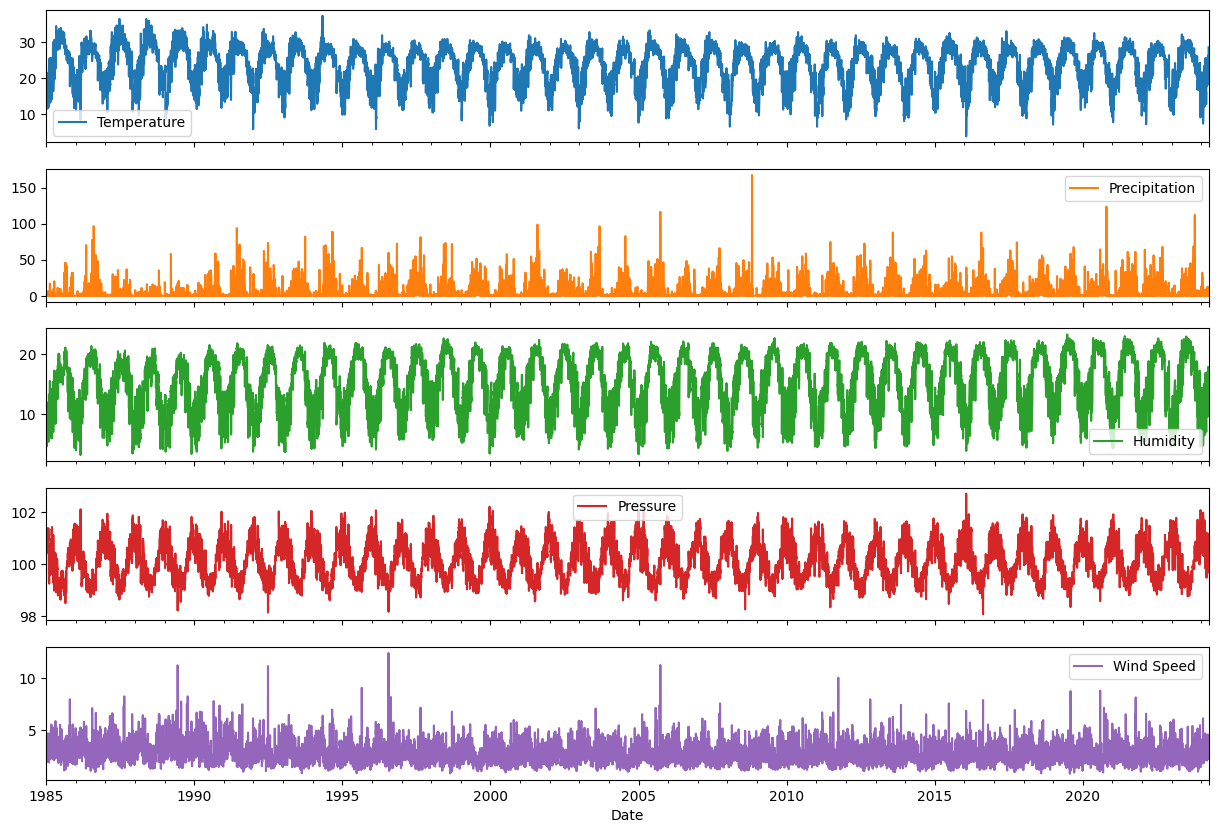

In [112]:
data.plot(subplots=True, figsize=(15, 10))

The distribution of each feature.

array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Precipitation'}>],
       [<Axes: title={'center': 'Humidity'}>,
        <Axes: title={'center': 'Pressure'}>],
       [<Axes: title={'center': 'Wind Speed'}>, <Axes: >]], dtype=object)

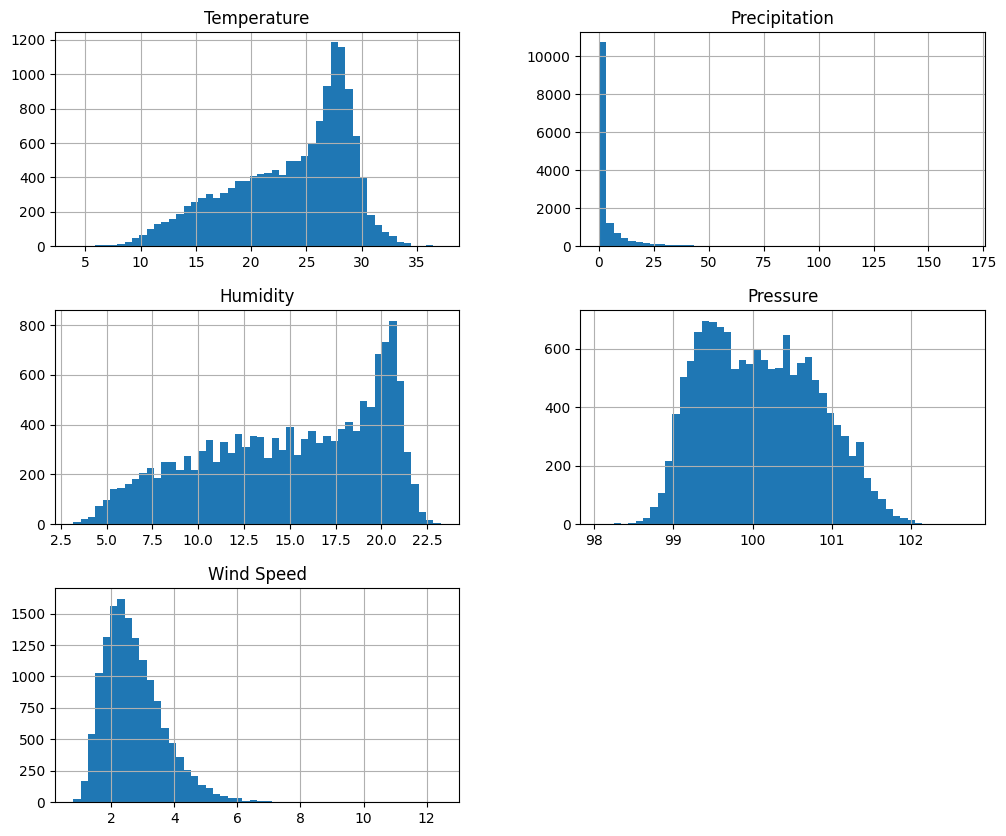

In [113]:
data.hist(figsize=(12, 10), bins=50)

### Correlation

Next, we check the correlated features by creating a heatmap of correlation matrix to understand the relationships between variables in the dataset.

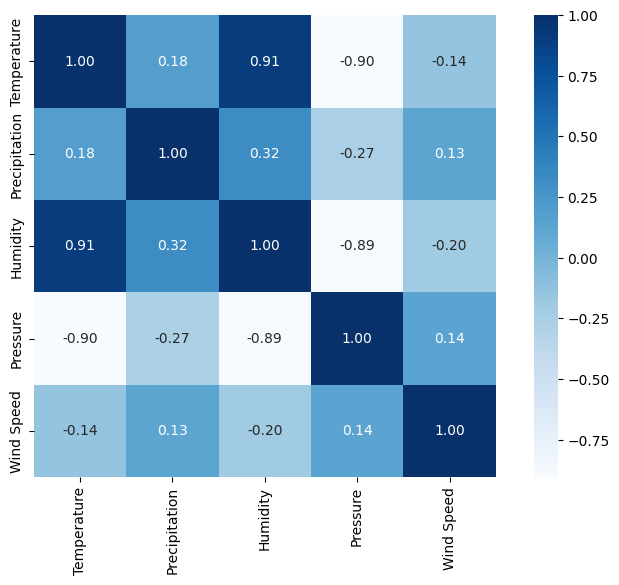

In [114]:
# Normal correlation matrix (heatmap)
plt.figure(figsize=(10,6))
ax = sns.heatmap(data.corr(), square=True, annot=True, fmt='.2f',cmap='Blues')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

We can see that the the features Temperature, Humidity are fairly strong positive correlation while the Pressure are high negative correlation with them.

###  Target Data for Time series model

#### Aggregation

In this project, we would like to the `Univariate time series` forecasting for the temperature data (target). It will read the data from the past and get the prediction for the future.

In [7]:
data_temp=data.Temperature

 First, we aggregate the temperature daily by using the `resample()` function from pandas. Here is the dataframe after aggregation.

In [8]:
data_temp=data_temp.resample('D').mean()
data_temp

Date
1985-01-01    16.52
1985-01-02    18.64
1985-01-03    20.19
1985-01-04    14.82
1985-01-05    13.51
              ...  
2024-03-27    24.65
2024-03-28    25.23
2024-03-29    24.05
2024-03-30    25.94
2024-03-31    28.42
Freq: D, Name: Temperature, Length: 14335, dtype: float64

Then, splitting the data into training and testing sets.

In [9]:
split_index=int(len(data_temp[:'2023'])) #split the data at the end of 2023
data_train=data_temp[:split_index]
data_test=data_temp[split_index:]

In [10]:
data_train_np=data_train.to_numpy() # convert to numpy array
data_test_np=data_test.to_numpy()

Make sure that the our data is 2D (n_samples, n_features), because the LSTM model expects a 3D input (n_samples, n_steps, n_features). And the next step will produce a 3D input.

In [11]:
data_train_np=np.expand_dims(data_train_np, axis=-1) #expand the dimensions of the array
data_test_np=np.expand_dims(data_test_np, axis=-1)

In [12]:
data_train_np.shape, data_test_np.shape

((14244, 1), (91, 1))

#### Normalizing data

Using `MinMaxScaler()` to transform the data to range [0,1]  
Scaling date to prevent values dominate the others & then neglected by Machine learning model.

In [13]:
scaler=MinMaxScaler() 

In [14]:
scale_data_train=scaler.fit_transform(data_train_np)
scale_data_test=scaler.fit_transform(data_test_np)

In [20]:
# # We can also use the StandardScaler to transform the data to have a mean of 0 and a standard deviation of 1
# # For example:
# data_std=StandardScaler().fit_transform(data)
# data_std=pd.DataFrame(data_std, columns=data.columns)
# data_std.describe().round(3)

#### Visualization and check stationary

1. *Visualizing the Temperature to see the general trend using the mean.*

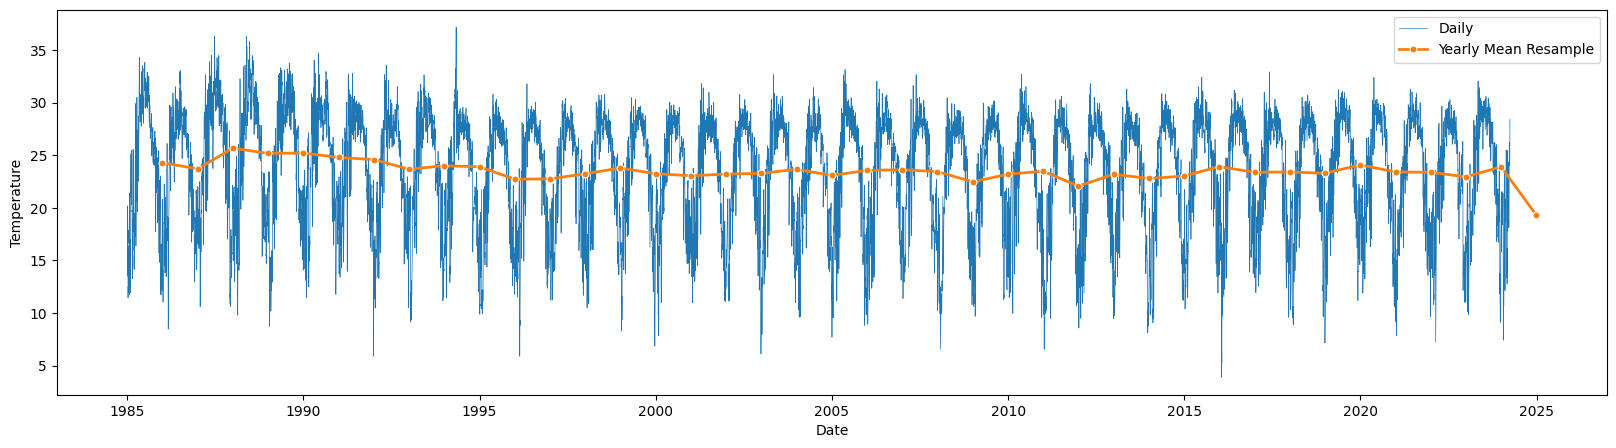

In [119]:
plt.figure(figsize=(20,5))
sns.lineplot(data_temp, markersize=4, linestyle='-',linewidth=0.5, label='Daily').set(xlabel='Date', ylabel='Temperature')
sns.lineplot(data_temp.resample('Y').mean(),marker='o', markersize=5, linestyle='-',linewidth=2, label='Yearly Mean Resample')
plt.legend()

Plot the ACF and PACF to identify the correlation  
It seems that there is a fairly high correlation between the values since the ACF values are above the confidence interval

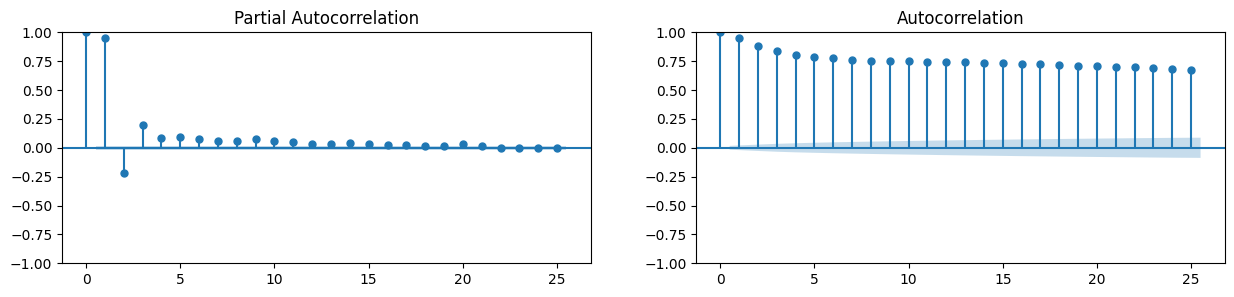

In [120]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(15, 3))
plot_pacf=sm.graphics.tsa.plot_pacf(data_temp, lags=25, ax=ax1)
plot_acf=sm.graphics.tsa.plot_acf(data_temp, lags=25, ax=ax2) 

* `ACF` graph provides the correlation between the time series & it's lags. For the above time series, we can observe a positive lowering correlation.  
* `PACF` graph provides the correlation between the time series and individual lags. These correlation coefficients are unlike the mutual correlations that are calculated in the presence of other features.  
* From the PACF graph above, the 1st lag is out of the confidence interval and probably the most significant lag. It probably dictates the pattern for the ACF graph where the next lag follows it's previous lag.

2. *Check stationary.*     

One of the most important thing before building a time series model is to check whether the time series data is stationary ( mean, variance, and autocorrelation do not change over time. ), or perhaps there might be trend and seasonality in there. For the case in this project, below is the decomposing of the data in the period of 2022 to obviously determine the Trend, Seasonality, Residuals.  

If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time. 

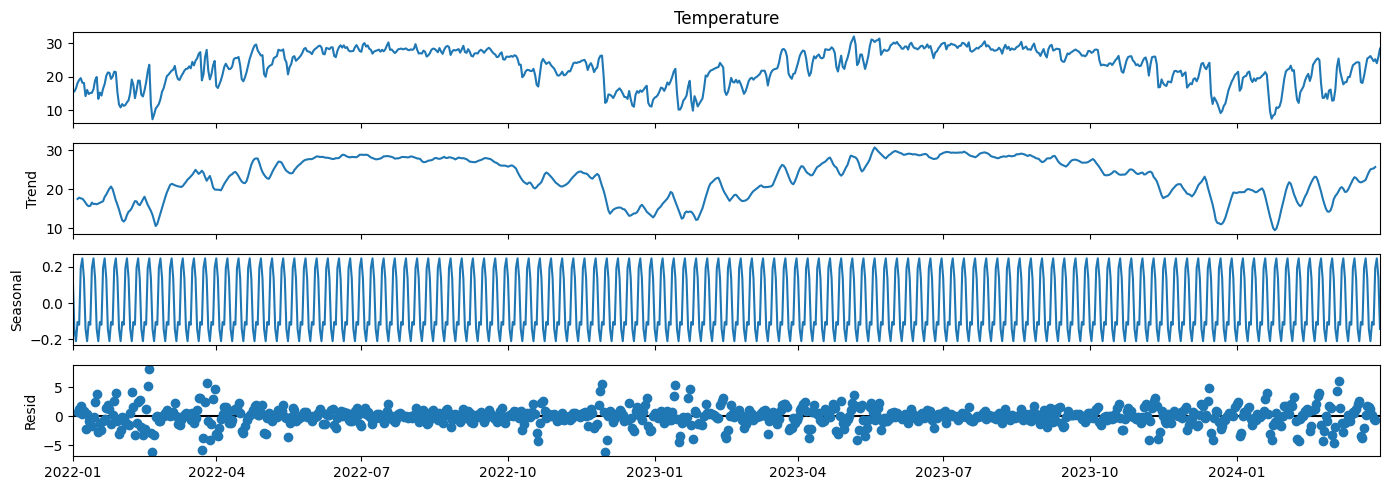

In [121]:
rcParams['figure.figsize'] = 14,5
decomposition =sm.tsa.seasonal_decompose(data_temp['2022':], model='additive') # plot from 2022 onwards
fig = decomposition.plot()
plt.show()

*To test stationarity, we will use `Augmented Dickey Fuller Test` :*  
- Null Hypothesis : It assumes that the time series is non-stationary.  
- Alternate Hypothesis : If the null hypothesis is rejected, then the time series is stationary.  
- Output of the Augmented Dickey Fuller Test include :  
Test Statistic  
   - p-value  
   - #Lags Used  
   - Number of Observations Used  
   - Critical Value (1%)  
   - Critical Value (5%)  
   - Critical Value (10%)  
* For the Null Hypothesis to be rejected and accepting that the time series is stationary, there are 2 requirements :  
Critical Value (5%) > Test Statistic  
p-value < 0.05

In [122]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries):
    dftest = sm.tsa.stattools.adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v,'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [123]:
# Test with raw data
ADF_test(data_temp)

Test statistic = -8.593
P-value = 0.000
Critical values :
	1%: -3.4308075998607617 - The data is  stationary with 99% confidence
	5%: -2.8617422386080547 - The data is  stationary with 95% confidence
	10%: -2.566877646857187 - The data is  stationary with 90% confidence


From the above test, the temperature data is already stationary with each interval confidence. In case non-stationary, we will utilize the Differencing method below to make the dataset more stationary. It's will simplify the complex patterns in the data and help our model learn better.

In [26]:
# # Diferencing method in case the data is not stationary
# data_diff = data_temp.diff()
# data_diff = data_diff.dropna()
# dec = sm.tsa.seasonal_decompose(data_diff['2023'],period = 12).plot() 
# plt.show()

In [27]:
# ADF_test(data_diff)

## III. Building Time Series models
- The simple linear trend line tends to group the data in a way that blends together or leaves out a lot of interesting and important details that exist in the actual data.  
- Creating a time series model in Python allows you to capture more of the complexity of the data and includes all of the data elements that might be important. It also makes it possible to make adjustments to different measurements, tuning the model to make it potentially more accurate.

### 1. SARIMA

Our data has seasonality in it and we can consider our problem as a `univariate time series`, we can also solve as `multivariate time series` but we would like to use the first one for this problem. Then it will be appropriate to use SARIMA. SARIMA stands for Seasonal Autoregressive Integrated Moving Average, which works similarly with ARIMA. However, ARIMA wouldn't be suitable for this problem since ARIMA only takes trend into account, but not seasonality. Meanwhile, SARIMA is a forecasting method which takes both trend and seasonality into account.

The notation of SARIMA then can be written as:

**SARIMA(p,d,q)(P,D,Q)m**

where:

`p` : Number of auto regressive terms.  
`d` : Number of differencing orders required to make the time series stationary.    
`q` : Number of lagged forecast errors in the prediction equation.  
`(P,D,Q,m)` is known as the Seasonal Order where (P,D,Q) are similar to the (p,d,q) of the ARIMA model.  
`m` is the time step for single seasonal period.  

In order to get the best prediction, it’s important to find the values of SARIMA(p,d,q)(P,D,Q)m that optimize a metric of interest. We will use a "grid search" to iteratively explore different combinations of parameters and pick the combination with the `lowest AIC (Akaike Information Criterion)` value.

Our sample data has a weekly seasonal pattern with about 30 years of data, and we aggregated it by day, meaning that each data point is one day, so m = 7.

In [17]:
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    mini = float('+inf')
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [36]:
sarima_grid_search(scale_data_train,7)

The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(1, 1, 1, 7) - AIC:-45843.57621219788


From the grid search operation above, we can see that the model with minimum AIC can be generated when the (p,d,q)(P,D,Q,m) parameters is `(1,0,1)(1,1,1,7)`. Now let's build SARIMA model with this set of parameters.


In [38]:
mod = sm.tsa.statespace.SARIMAX(scale_data_train,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_sarima = mod.fit()
print(model_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                14244
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood               22926.788
Date:                           Tue, 07 May 2024   AIC                         -45843.576
Time:                                   00:29:07   BIC                         -45805.761
Sample:                                        0   HQIC                        -45830.997
                                         - 14244                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9225      0.004    251.167      0.000       0.915       0.930
ma.L1          0.3014      0.007     43.514

- Before we use the SARIMA model for prediction, it's always best to find out the property of the model, such as the Residual error and the Quantiles. From the diagnostics below, although the residuals look not perfect, which are not really normally distributed and centered around zero with the exception of few data points, meaning that the model SARIMA is a good fit.  
- The Q-Q plot on the bottom left shows that the ordered distribution of Residuals (blue dots) follows the linear trend of the sample taken from a standard normal distribution. Again, it is indicated that our model is good fit.



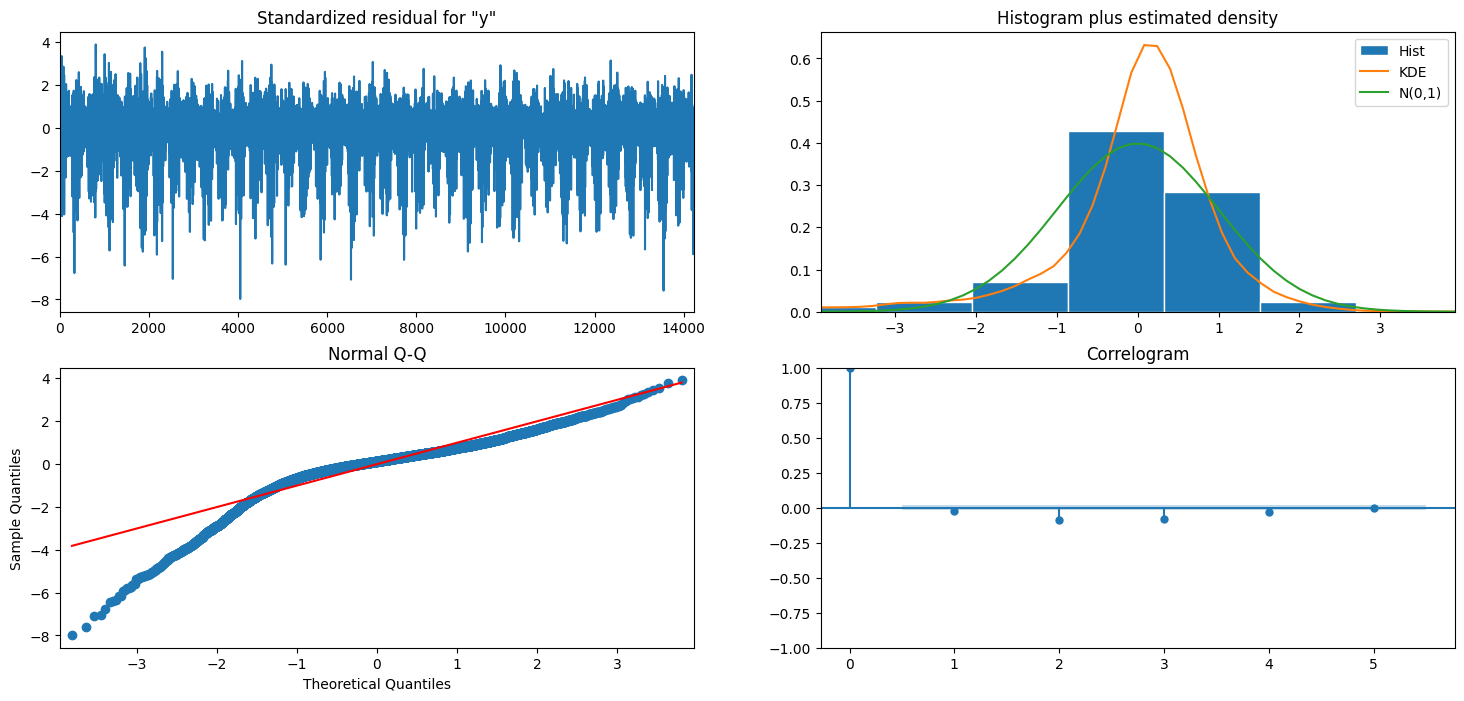

In [39]:
model_sarima.plot_diagnostics(lags=5, figsize=(18, 8))
plt.show()

Now we can predict the temperature in our data. In the following code and plot, I am going to use the `In - Sample Forecasting `. For this method, we use the `rolling` forecast method, we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.


In [59]:
history = [x for x in scale_data_train]
predictions = []

for i in range(len(scale_data_test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (1,0,1),seasonal_order = (1,1,1,7))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    pred = output[0]
    predictions.append(float(pred))
    
    obs = scale_data_test[i]
    history.append(obs)

In [86]:
# Take the data back to the original scale
predictions_descaled = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

In [95]:
# Change the data into a pandas series
predictions_series = pd.Series(predictions_descaled.flatten(), index=data_test.index)

For this case, the data from Jan 2024 onwards is treated as test data that needs to be compared with the prediction by SARIMA model.

In [96]:
# Create a dataframe with the actual and predicted values
df_SARIMA=pd.DataFrame({'Actual': data_test, 'Predicted': predictions_series, 'Residuals': data_test-predictions_series})
df_SARIMA.head()

,Actual,Predicted,Residuals
Date,,,
2024-01-01,20.95,18.135289,2.814711
2024-01-02,21.48,21.774159,-0.294159
2024-01-03,15.80,21.307281,-5.507281
2024-01-04,16.57,14.492677,2.077323
2024-01-05,19.63,17.469830,2.160170


The performance of the SARIMA model would be improved if there are more data, because the more data it trains, the better this model to recognize the seasonality.

### 2. Long Short-Term Memory (LSTM)  
In this part, we will forecast the daily temperature by using the deep learning model, [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).     
`LSTM` stands for Long-Short Term Memory, which is one of `Recurrent Neural Network`
architecture mostly popular for the application of Natural Language Processing.


Because of our dataset is stationary, hence we need to transform the time series as supervised data and construct the training and testing input/output pairs for the model. These can be done by using `TimeseriesGenerator()` function. In our case, we will do with the look back length of 7.

In [15]:
n_features=1
look_back=7
# Let's build two timeseries generators for the training and testing data
train_generator = TimeseriesGenerator(scale_data_train,scale_data_train, length=look_back, batch_size=10, stride=1)
test_generator = TimeseriesGenerator(scale_data_test, scale_data_test, length=look_back, batch_size=10, stride=1)

##### Building LSTM model

- We have selected the appropriate number of hidden layers and the number of
neurons in each of them. 
- We used Adam optimizer for faster training and trained for 100 iterations using batch size 10, It took us near 150s for all iterations. 
- And for regression, the loss used is generally root mean square error.

In [18]:
n_neurons=32
model_lstm = Sequential()
model_lstm.add(LSTM(n_neurons,input_shape=(look_back, n_features), return_sequences=True))
model_lstm.add(LSTM(n_neurons, return_sequences=True))
model_lstm.add(LSTM(n_neurons))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
lr_reduced=ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)

In [21]:
model_lstm.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[lr_reduced], verbose=0)

Epoch 1/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0246 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 2/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0060 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 3/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0026 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 4/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 5/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0023 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 6/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0024 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 7/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0024 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 8/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0022 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 9/100
1424/1424 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0023 - val_loss: 0.0100 - learn

After model training, we can use the model to predict the test data. After that, we need preprocess the prediction because we have normalized the data before. Hence, we basically need to inverse the scale back to the original and reshape it to 1D array so that we can compare the prediction result with the original time series data.

In [22]:
prediction_lstm = model_lstm.predict(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [23]:
prediction_lstm_descaled = scaler.inverse_transform(prediction_lstm)
data_test_descaled = scaler.inverse_transform(scale_data_test)

prediction_lstm_descaled=prediction_lstm_descaled.flatten()
data_test_descaled=data_test_descaled.flatten()

data_test_descaled.shape, prediction_lstm_descaled.shape

((91,), (84,))

In [31]:
# Make a DataFrame for the actual and predicted values for the last 84 days
index_date=data_temp['2024':].index
df_LSTM=pd.DataFrame({'Actual': data_test_descaled[look_back:], 'Predicted': prediction_lstm_descaled,'Residuals': data_test_descaled[look_back:]-prediction_lstm_descaled}, index=index_date[look_back:])
df_LSTM.head()

,Actual,Predicted,Residuals
Date,,,
2024-01-08,21.24,20.176142,1.063858
2024-01-09,21.55,21.298340,0.251660
2024-01-10,19.22,20.738695,-1.518695
2024-01-11,18.41,18.171162,0.238838
2024-01-12,19.48,18.676704,0.803296


## IV. Result

### Model Comparison

In [110]:
pd.DataFrame({'Model': ['SARIMA', 'LSTM'],
              'R_Squared': [r2_score(data_test, predictions_series), r2_score(data_test_descaled[look_back:], prediction_lstm_descaled)],
              'Mean Squared Error': [mean_squared_error(data_test, predictions_series), mean_squared_error(data_test_descaled[look_back:], prediction_lstm_descaled)]
              })

,Model,R_Squared,Mean Squared Error
0,SARIMA,0.798194,4.284794
1,LSTM,0.818954,4.102445


After analysis two models it is observed that time series `LSTM` is better than `SARIMA` for this problem. Also the `R_Squared` is very crucial as
high value of R_Squared result in how well the data fit the regression model. Table above depicts the comparison between the two models.

[Text(0.5, 1.0, 'SARIMA Model Prediction')]

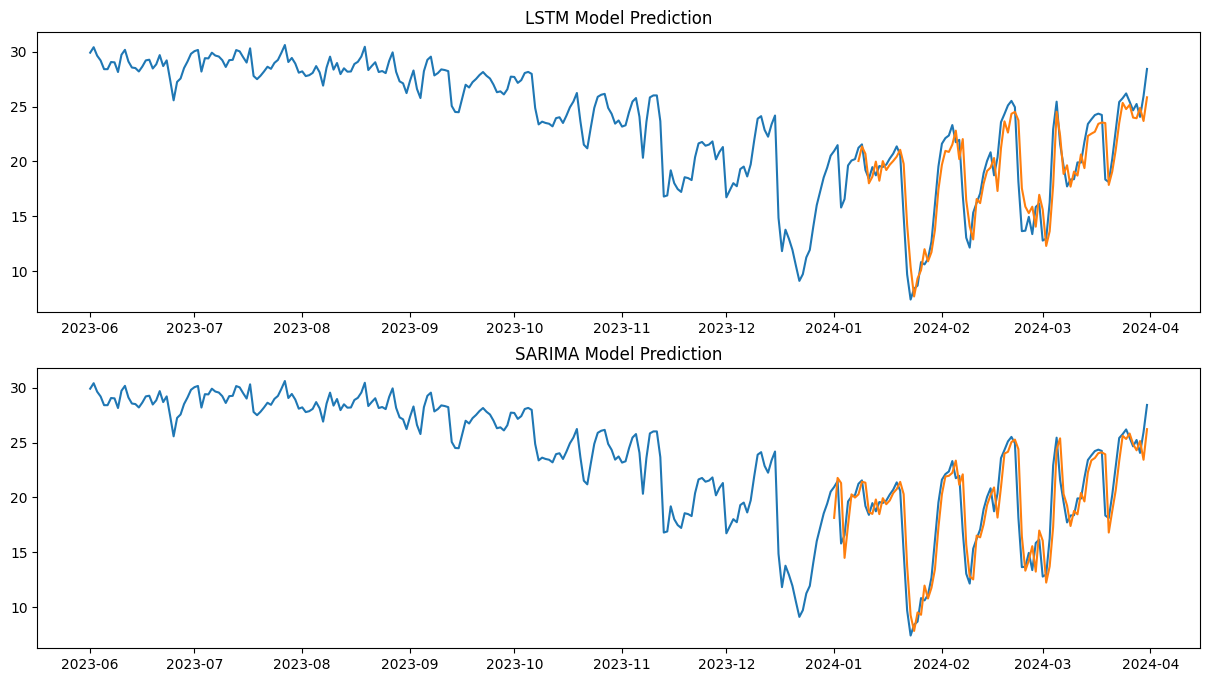

In [111]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(15, 8))
ax1.plot(data_temp['2023-06':], label='Observed')
ax1.plot(df_LSTM['Predicted'], label='LSTM Prediction')
ax1.set(title='LSTM Model Prediction')

ax2.plot(data_temp['2023-06':], label='Observed')
ax2.plot(df_SARIMA['Predicted'], label='SARIMA Prediction')
ax2.set(title='SARIMA Model Prediction')

Figure shows the Temperature on y-axis and the time from 2023-06 to 2024-04 on the x-axis using two model LSTM and SARIMA, the temperature predictedis represented by orange color and the actual temperature is represented by blue color.

### Conclusion

In this report, weather data is considered with different attributes for weather forecasting. The weather forecasting experiment was carried out to analyze the performance of different machine learning techniques. We trained two different models on this data time series `LSTM` and `SARIMA`. We then used these models to predict weather and calculated root mean square error from the actual data. Finally, we found out that time series using `LSTM` is a better method for weather forecasting.

## V. References

[Long-Sort Term memory](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Data Access](https://power.larc.nasa.gov/data-access-viewer/)

[SARIMA model](https://phamdinhkhanh.github.io/2019/12/12/ARIMAmodel.html)

[Augmented Dickey Fuller Test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)